Playing Card Detection using YOLOv5

Trained on 600+ images using 500 + 106 train and validation split

For training used yolov5 <b>custom object detection</b><br>
<a href= "https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data">Link</a> <br>
The model are exported in <b>Onnx</b> format to infere in opencv dnn

Card detection and Number/card recoginition are different models

Also images are annotated by hand and some are <b>computer generated</b> image + annotation with different background, will attach link for dataset and scripts

For inferencing Used <b>cv2 dnn</b>  module, we can use openvino or tensorrt for speed boost

Code below infere one image of card and no.s on it, we can make changes for video inferenceing and webcam as well

Model accuracy is not good enough since <b>data is limited</b> 
so classes are switching.
If I get more data will update models with better accuracy

Dataset and dataset creating scripts added in drive,can check it here,also added models if you want to test
https://drive.google.com/drive/folders/1TvaS_z3gIUGeUkZXhE3CmMQmAM2ZZtAH?usp=sharing


In [1]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt


In [2]:
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45

# Text parameters.
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

# Colors.
BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)

In [3]:
def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)

In [4]:
def pre_process(input_image, net):
      # Create a 4D blob from a frame.
      blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)

      # Sets the input to the network.
      net.setInput(blob)

      # Run the forward pass to get output of the output layers.
      outputs = net.forward(net.getUnconnectedOutLayersNames())
      return outputs

In [8]:
def post_process(input_image, outputs,classes):
      # Lists to hold respective values while unwrapping.
      class_ids = []
      confidences = []
      boxes = []
      # Rows.
      rows = outputs[0].shape[1]
      image_height, image_width = input_image.shape[:2]
      # Resizing factor.
      x_factor = image_width / INPUT_WIDTH
      y_factor =  image_height / INPUT_HEIGHT
      # Iterate through detections.
      for r in range(rows):
            row = outputs[0][0][r]
            confidence = row[4]
            # Discard bad detections and continue.
            if confidence >= CONFIDENCE_THRESHOLD:
                  classes_scores = row[5:]
                  # Get the index of max class score.
                  class_id = np.argmax(classes_scores)
                  #  Continue if the class score is above threshold.
                  if (classes_scores[class_id] > SCORE_THRESHOLD):
                        confidences.append(confidence)
                        class_ids.append(class_id)
                        cx, cy, w, h = row[0], row[1], row[2], row[3]
                        left = int((cx - w/2) * x_factor)
                        top = int((cy - h/2) * y_factor)
                        width = int(w * x_factor)
                        height = int(h * y_factor)
                        box = np.array([left, top, width, height])
                        boxes.append(box)
      # Perform non maximum suppression to eliminate redundant, overlapping boxes with lower confidences.
      indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
      for i in indices:
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]             
            # Draw bounding box.             
            cv2.rectangle(input_image, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)
            # Class label.                      
            label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])             
            # Draw label.             
            draw_label(input_image, label, left, top)
      return input_image

In [9]:
def get_detection(image,model,class_file):
  classesFile = class_file
  classes = None
  with open(classesFile, 'rt') as f:
        classes = f.read().rstrip('\n').split('\n')
  # Load image.
  frame = cv2.imread(image)
  # Give the weight files to the model and load the network using them.
  modelWeights = model
  net = cv2.dnn.readNet(modelWeights)
  # Process image.
  detections = pre_process(frame, net)
  img = post_process(frame.copy(), detections,classes)
  """
  Put efficiency information. The function getPerfProfile returns the overall time for inference(t) 
  and the timings for each of the layers(in layersTimes).
  """
  t, _ = net.getPerfProfile()
  label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
  print(label)
  cv2.putText(img, label, (20, 40), FONT_FACE, FONT_SCALE,  (0, 0, 255), THICKNESS, cv2.LINE_AA)
  return img


Card detection from image

Inference time: 366.08 ms


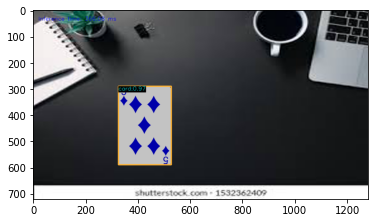

In [10]:
img = get_detection("sample/5_of_diamonds_bb5.png","models/card.onnx","classes1.txt")
cv2.imwrite("output_file1.jpg",img)
plt.imshow(img)
plt.show()

Detecting card name from image ,wanted to do it on cropped image of card <br> but since time and data was limited couldnt get accuracy

Inference time: 464.17 ms


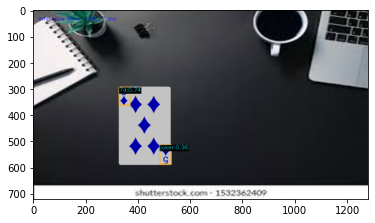

In [11]:
img = get_detection("sample/5_of_diamonds_bb5.png","models/no_of_card.onnx",'classes.txt')
cv2.imwrite("output_file2.jpg",img)
plt.imshow(img)
plt.show()